## 🐎 Horse-Level Attributes and Their Impact on Win Rate

In this notebook, we explore **attributes of the individual horse** — characteristics known before the race that may influence performance.

Unlike contextual factors like field size or going, these features are about the **horse itself**.

We focus on:
- Physical characteristics (e.g. **age**, **sex**, **weight**)
- Basic identifiers (e.g. **saddlecloth number**, **horse name** — for reference only)
- Whether a horse **finished or failed to finish**

This helps us understand whether certain types of horses — by age, sex, or weight — tend to perform better, and whether these factors should be included in later models.


## 📦 Setup: Load UK & Ireland Flat Race Data

We begin by loading a pre-filtered dataset saved in efficient **Feather format**, containing only **UK and Irish flat races** from our full raceform database.


In [4]:
import pandas as pd
flat_df = pd.read_feather("../db/data_flat_uk_ire.feather")


print(flat_df.shape)


(473928, 41)


### 🎂 Win Rate by Horse Age

Horse age is a fundamental variable in racing. Age influences:
- Physical maturity and development
- Experience in racing conditions
- Eligibility for certain race types (e.g. 2yo maidens, veteran handicaps)

In general:
- **2-year-olds (2yo)** are inexperienced and often race in separate divisions
- **3–5yo** tend to be physically mature and are often at peak performance
- **Older horses (6yo+)** may be more experienced but may also decline in ability or be used in lower-grade races

In this section, we group runners by age and calculate win rates to see whether age has a clear relationship with performance — and to flag any age bands that stand out as over- or underperforming.


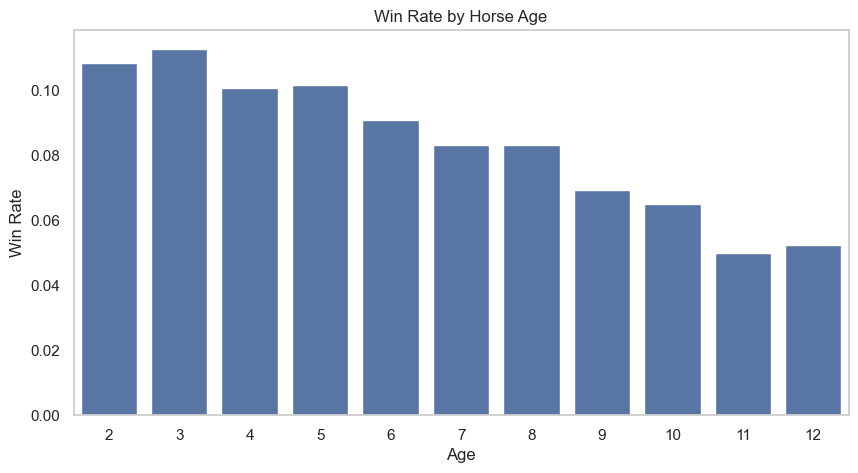

In [5]:
# Filter valid ages
flat_age_df = flat_df[flat_df['age'].notnull()].copy()
flat_age_df = flat_age_df[flat_age_df['age'].between(2, 12)]  # Typical racing ages

# Group and calculate win rate
age_win_rate = (
    flat_age_df.groupby('age', observed=True)['won']
    .mean()
    .reset_index()
    .rename(columns={'won': 'win_rate'})
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='age', y='win_rate', data=age_win_rate)
plt.title('Win Rate by Horse Age')
plt.xlabel('Age')
plt.ylabel('Win Rate')
plt.grid(axis='y')
plt.show()


## 🧒 Win Rate by Horse Age

We grouped flat-race runners by their age and calculated win rates for each group.

### 🔍 Observations:
- **3-year-olds** have the highest win rate, slightly outperforming 2-year-olds.
- There is a **steady decline in win rate as age increases**.
- Horses aged **7 and up** win significantly less often, with win rates under 7% from age 9 onwards.
- Very old runners (11–12 years) rarely win.

### ⚠️ Important Caveat: Survivor Bias
Older horses that remain in racing are a **select group** — typically sound, durable, and placed in lower-class or specialist races. Their declining win rate doesn’t mean they’re all bad horses — rather, it reflects the **natural selection effect** where less competitive horses have already been retired.

### 🧠 Why This Matters:
Age is a fundamental predictor of performance. These patterns help inform:
- Targeting certain age groups in specific race types
- Understanding lifecycle trends in a horse’s racing career
- Adjusting model expectations when comparing young vs older runners


## 🧬 Horse Sex – Background, Physiology, and Why We're Not Plotting It

Our dataset records each horse's sex using the following codes:

| Code | Description                                  |
|------|----------------------------------------------|
| `g`  | Gelding – castrated male                     |
| `c`  | Colt – male under 4 years old                |
| `h`  | Horse – entire male, usually aged 5 or more  |
| `f`  | Filly – female under 4 years old             |
| `m`  | Mare – female aged 4 or older                |
| `r`  | Rig – male with undescended testicle (rare)  |

---

### 🧠 Why Horse Sex Influences Racing — But Not Always Predictively

Horse sex plays a major role in training and career planning, but not always in direct performance outcomes.

#### 🔄 Hormonal Cycles in Mares
- Female horses (mares and fillies) can experience mood swings and behavioural changes due to their heat cycles.
- This hormonal variation can affect focus, responsiveness, and overall race performance — some days they're electric, others off the boil.
- This inconsistency is one reason mares are seen as less predictable in open competition.

#### 💼 Male Preferences and Consistency
- Male horses — especially **geldings** — are generally preferred in open racing.
- Geldings are calmer, more focused, and less reactive to stress, noise, or other horses.
- Colts can be powerful but temperamental; gelding them makes them more manageable and mentally reliable.

> A focused horse is a fast horse — and consistency is everything in competitive racing.

---

### 🤔 Why We're Not Charting Win Rates by Sex

While sex does influence how a horse is managed and where it races, it is:
- **Not a strong standalone predictor** of win probability
- **Highly confounded** by race eligibility and career stage (e.g. fillies retired early, geldings race longer)
- Often just a **proxy** for race type or career path rather than inherent ability

So instead of plotting sex-based win rates — which would mostly reflect **entry patterns**, not ability — we’re treating sex as useful background context rather than a variable for direct modelling.




## 📊 Official Rating (OR) – Distribution and Performance

The **Official Rating (`or`)** is a number assigned by official handicappers to summarise a horse’s racing ability. In flat racing, this typically ranges from around 30 (low-grade handicapper) to 120+ (elite Group-level horses).

Although it’s not an innate trait like age or sex, we treat it here as a **performance-based horse attribute** — a proxy for form, class, and career trajectory.

---

### 🧠 What Is OR and Why It Matters

- OR reflects the horse’s **current level of ability** based on past performance.
- It directly influences **how much weight** a horse carries in handicap races.
- It determines **entry eligibility** for certain race types.
- It’s one of the most widely used indicators by trainers, punters, and analysts alike.

---

### ⚠️ Not All Horses Have a Rating

Not every flat horse is assigned an OR:

- Horses must usually run **at least three times**, or perform well in a single qualifying race (e.g. win a maiden/novice), to be assessed.
- ORs are **assigned manually** by handicappers, not automatically.
- Horses in early stages of their career — or those retired quickly — may never receive one.

In our dataset, **76.4% of flat runners have an official rating**.

We’ll now explore:
1. How these ratings are distributed across the dataset
2. Whether higher-rated horses actually win more often


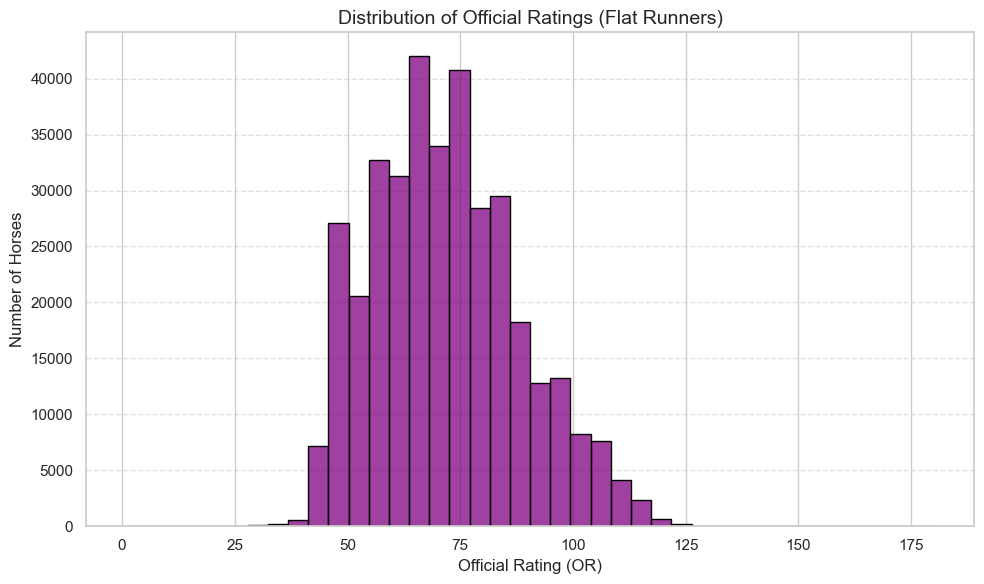

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing ratings
or_values = flat_df['or'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(or_values, bins=40, kde=False, color='purple', edgecolor='black')

plt.title("Distribution of Official Ratings (Flat Runners)", fontsize=14)
plt.xlabel("Official Rating (OR)")
plt.ylabel("Number of Horses")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 📊 Distribution of ORs

**Key Observations:**

- The distribution is approximately **normal**, with most horses rated between **50 and 90**.
- The **peak** is around **65–75**, which likely corresponds to the majority of **middle-grade handicaps**.
- There are some runners with ratings **above 100** — these are typically **higher-class horses** running in **top-level handicaps** or **conditions races**.

This plot gives us a useful baseline to understand what a "typical" horse looks like in terms of official rating.  
We’ll explore how this rating relates to actual race outcomes next.

In [27]:
# Set up 5-point OR bands
bins = list(range(30, 131, 5))
labels = [f"{b}-{b+5}" for b in bins[:-1]]

# Filter to handicap races with OR
handicap_df = flat_df[
    flat_df['race_name'].str.contains("handicap", case=False, na=False) &
    (flat_df['or'].notnull())
].copy()
handicap_df['or_band'] = pd.cut(handicap_df['or'], bins=bins, labels=labels, right=False)

# Group and prepare stats
band_stats = (
    handicap_df.groupby('or_band', observed=True)['won']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'win_rate', 'count': 'runners'})
)

# Filter to reliable bands
band_stats = band_stats[band_stats['runners'] >= 1000]


In [25]:
print(band_stats.shape)
print(band_stats['win_rate'].describe())

(14, 3)
count    14.000000
mean      0.091588
std       0.022938
min       0.036697
25%       0.083005
50%       0.095798
75%       0.108799
max       0.119250
Name: win_rate, dtype: float64


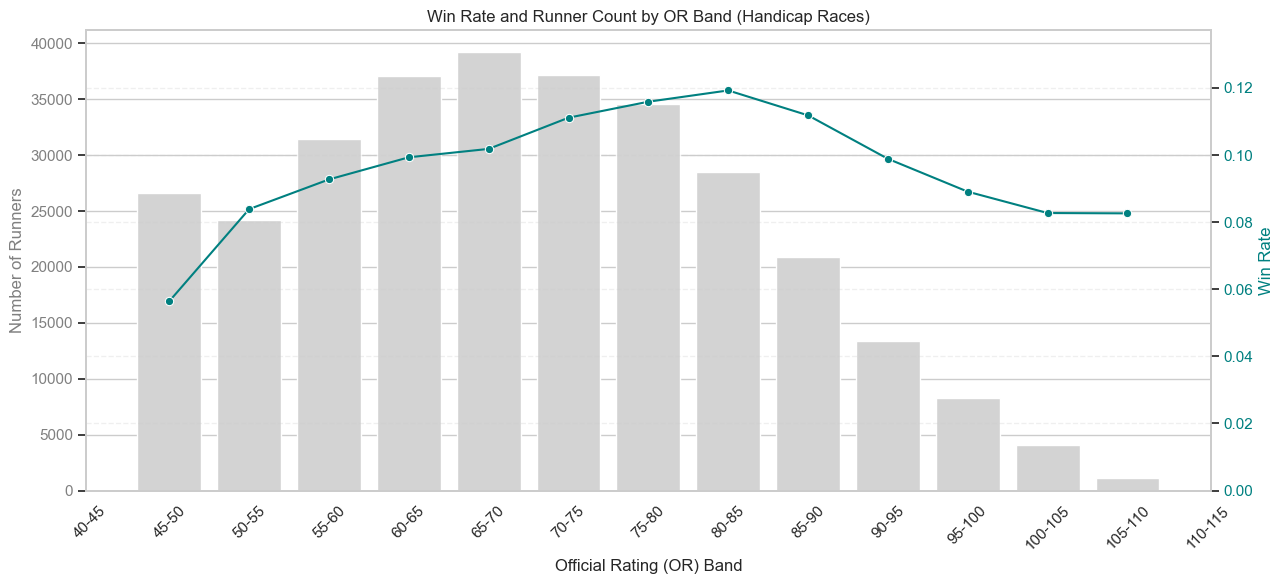

In [28]:
# Plot
fig, ax1 = plt.subplots(figsize=(13, 6))

# Bar chart: runner count
sns.barplot(data=band_stats, x='or_band', y='runners', color='lightgrey', ax=ax1)
ax1.set_ylabel("Number of Runners", color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

# Line plot: win rate
ax2 = ax1.twinx()
sns.lineplot(data=band_stats, x='or_band', y='win_rate', marker='o', color='teal', ax=ax2)
ax2.set_ylabel("Win Rate", color='teal')
ax2.tick_params(axis='y', labelcolor='teal')
ax2.set_ylim(0, band_stats['win_rate'].max() * 1.15)

# Aesthetics
ax1.set_title("Win Rate and Runner Count by OR Band (Handicap Races)")
ax1.set_xlabel("Official Rating (OR) Band")
ax1.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 🐎 Win Rate by Official Rating (OR) Band – Handicap Races

This chart examines how a horse’s **Official Rating (OR)** relates to its **win rate** in UK/IRE flat handicap races. Ratings are grouped into 5-point bands, and only bands with **≥ 1,000 runners** are included to ensure statistical reliability.

#### Key Observations:

- **Ratings of 70–85 perform best**: These horses achieve the highest win rates, peaking just over **12%**.
- **Mid-tier ratings dominate**: The majority of runners fall between **60 and 80**, which aligns with the typical structure of UK handicap races.
- **High-rated horses (90+) see diminishing win rates**: These horses often face stronger competition or are more finely handicapped, which may limit their winning potential.
- **Lower-rated horses (under 60)** also show reduced success, potentially due to limited ability or larger, more unpredictable fields in lower-grade races.

#### Interpretation:

- A clear **sweet spot** appears in the **65–85 range**, where horses are strong enough to be competitive but not so highly rated that they carry excessive weight.
- This insight could help inform strategy, such as:
  - Focusing on in-form mid-OR horses in well-matched fields.
  - Being cautious with outliers (both very high and very low rated horses) unless justified by context or price.

